# Visitor to Customer: Calculating the Probability of an Online Sale Using the Logit Model

In this notebook, we look to explain factors that make a person more or less likely to make a purchase at an online store. To do this, we've chosen to use a logit model. The dependent variable will be discrete (1 if yes, 0 if no). Marginal effects can be obtained from a logit regression to show how each factor makes an the dependent variable be a 1. 

The dataset we're using for this study is a log of web traffic to Google's Merchandise store in the time period between Setpember 2016 and January 2017.  We begin by loading the necessary libraries.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np
%matplotlib inline

Now, we load the dataset. This version of the dataset has already been adjusted to unpack some JSON objects.

In [2]:
df = pd.read_csv('fixed_train.csv')
print(df.shape)
print(df.columns)

/mnt/c/Users/ok/CondaConda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(903653, 51)
Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'sessionId',
       'socialEngagementType', 'visitId', 'visitNumber', 'visitStartTime',
       'browser', 'browserSize', 'browserVersion', 'deviceCategory',
       'flashVersion', 'isMobile', 'language', 'mobileDeviceBranding',
       'mobileDeviceInfo', 'mobileDeviceMarketingName', 'mobileDeviceModel',
       'mobileInputSelector', 'operatingSystem', 'operatingSystemVersion',
       'screenColors', 'screenResolution', 'city', 'cityId', 'continent',
       'country', 'latitude', 'longitude', 'metro', 'networkDomain',
       'networkLocation', 'region', 'subContinent', 'bounces', 'hits',
       'newVisits', 'pageviews', 'transactionRevenue', 'visits', 'adContent',
       'adwordsClickInfo', 'campaign', 'campaignCode', 'isTrueDirect',
       'keyword', 'medium', 'referralPath', 'source'],
      dtype='object')


There are a lot of columns to work through. We'll have to focus our study on a few variables. The first thing to do is to set up our dependent variable. We create a new variable with the name **"madePurchase."** This variable will be 1 if "transactionRevenue" is not null, and 0 otherwise. 

In [3]:
df['madePurchase'] = np.where(df['transactionRevenue'].isnull(), 0, 1)
df['madePurchase'].head()

0    0
1    0
2    0
3    0
4    0
Name: madePurchase, dtype: int64

The **"isMobile"** variable is a boolean (True or False). We will transform this to an integer, so that it displays as 0 or 1.

In [4]:
df['isMobile'] = df['isMobile'].astype(int)
df['isMobile'].head()

0    0
1    0
2    0
3    0
4    1
Name: isMobile, dtype: int64

Let's get a better idea of how using a mobile device is related to whether or not a visitor makes a purchase. First we take a look at the total visits, split between desktop and mobile device users.

/mnt/c/Users/ok/CondaConda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0,'Mobile Device'), Text(0,0,'Desktop')]

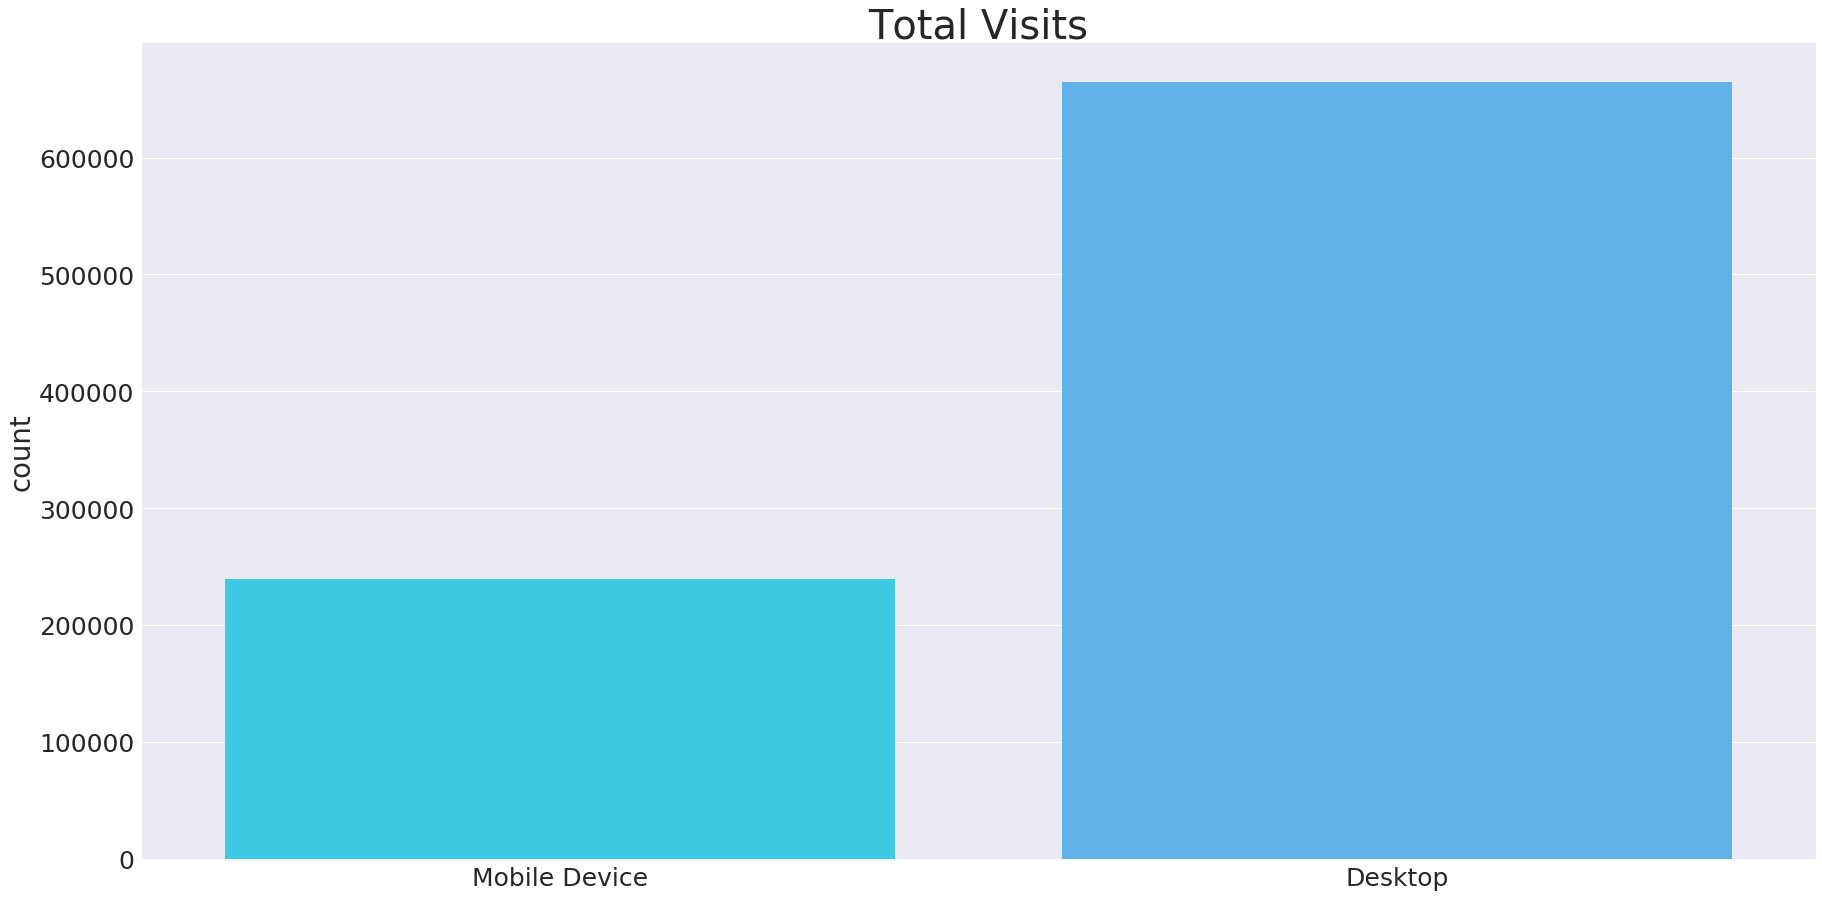

In [5]:
sns.set(rc={'figure.figsize' : (30,15)}, style='darkgrid')
sns.set_context("talk")
sns.set(font_scale=2.5)
sns.set_palette('cool')

ax = sns.countplot(x="isMobile", data=df, order=[1, 0])
ax.set_title("Total Visits", fontsize=40)
ax.set_xlabel("")
ax.set_xticklabels(['Mobile Device', 'Desktop'])

Now let's look at this relationship among only visitors who made a purchase.

/mnt/c/Users/ok/CondaConda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0,'Mobile Device'), Text(0,0,'Desktop')]

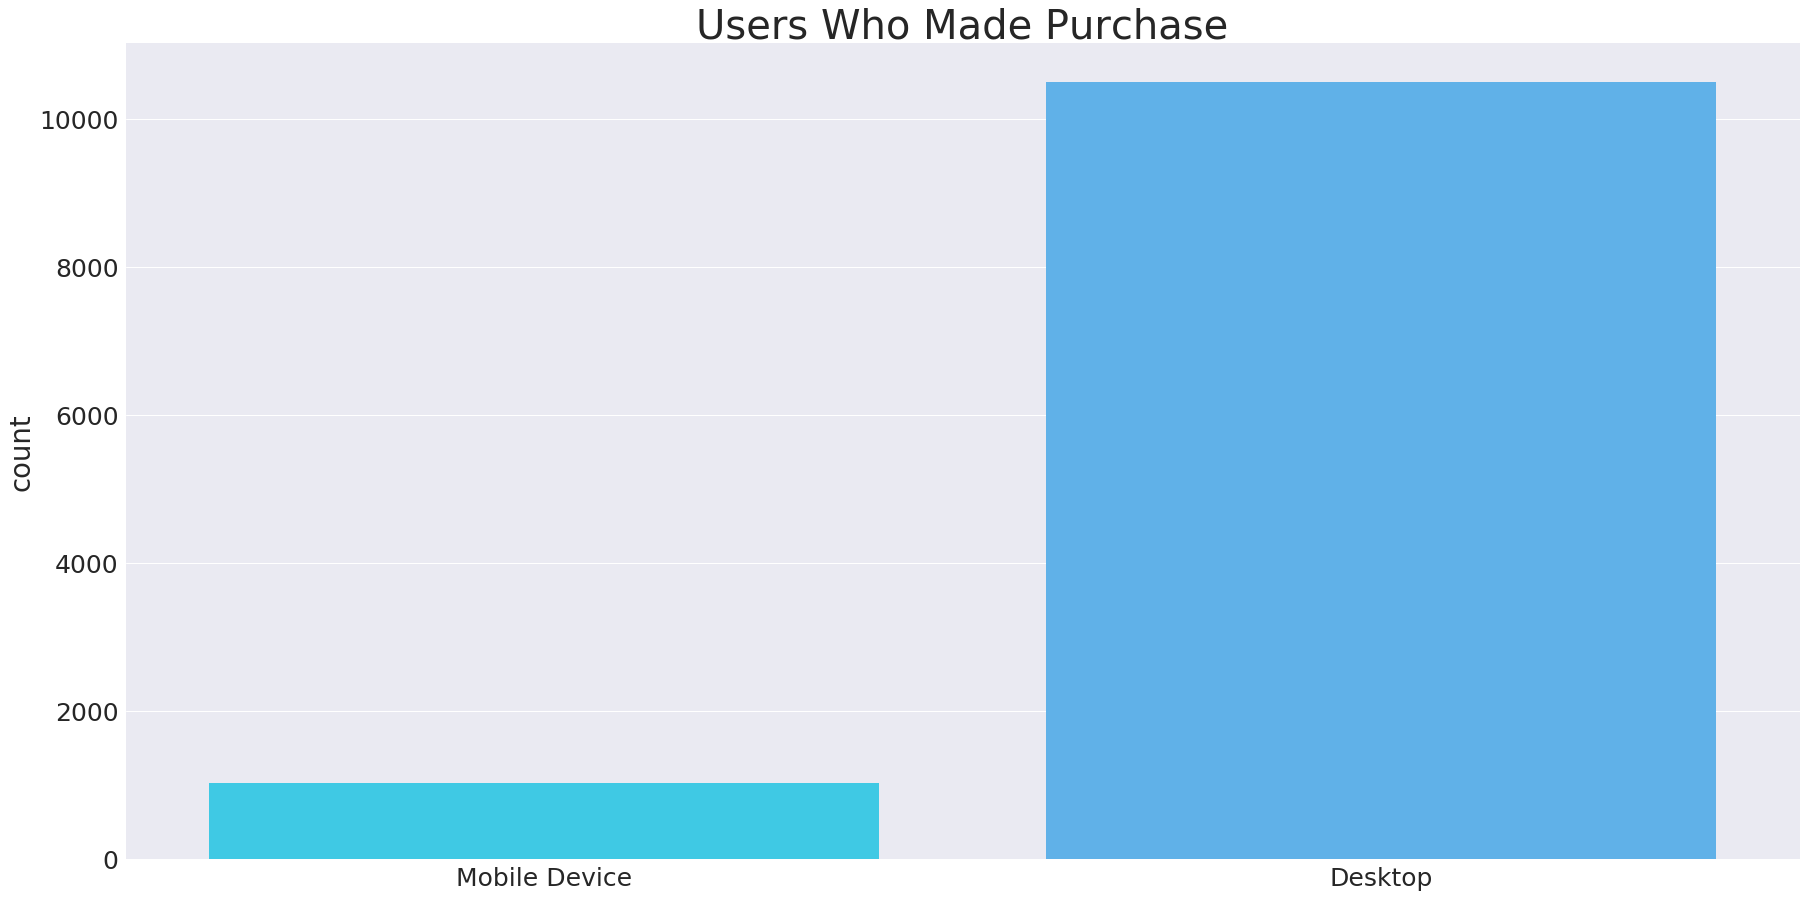

In [6]:
ax = sns.countplot(x="isMobile", data=df.loc[df['madePurchase'] == 1], order=[1, 0])
ax.set_title("Users Who Made Purchase", fontsize=40)
ax.set_xlabel("")
ax.set_xticklabels(['Mobile Device', 'Desktop'])

There is large change in proportion from total to those who made a purchase.

Location is another factor we believe affects whether or not a visitor makes a purchase. We have chosen to use **Continent** as an indicator for location.

Below is the total number of visits to the store, separated by continent of origin.

/mnt/c/Users/ok/CondaConda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Visitor Counts by Continent')

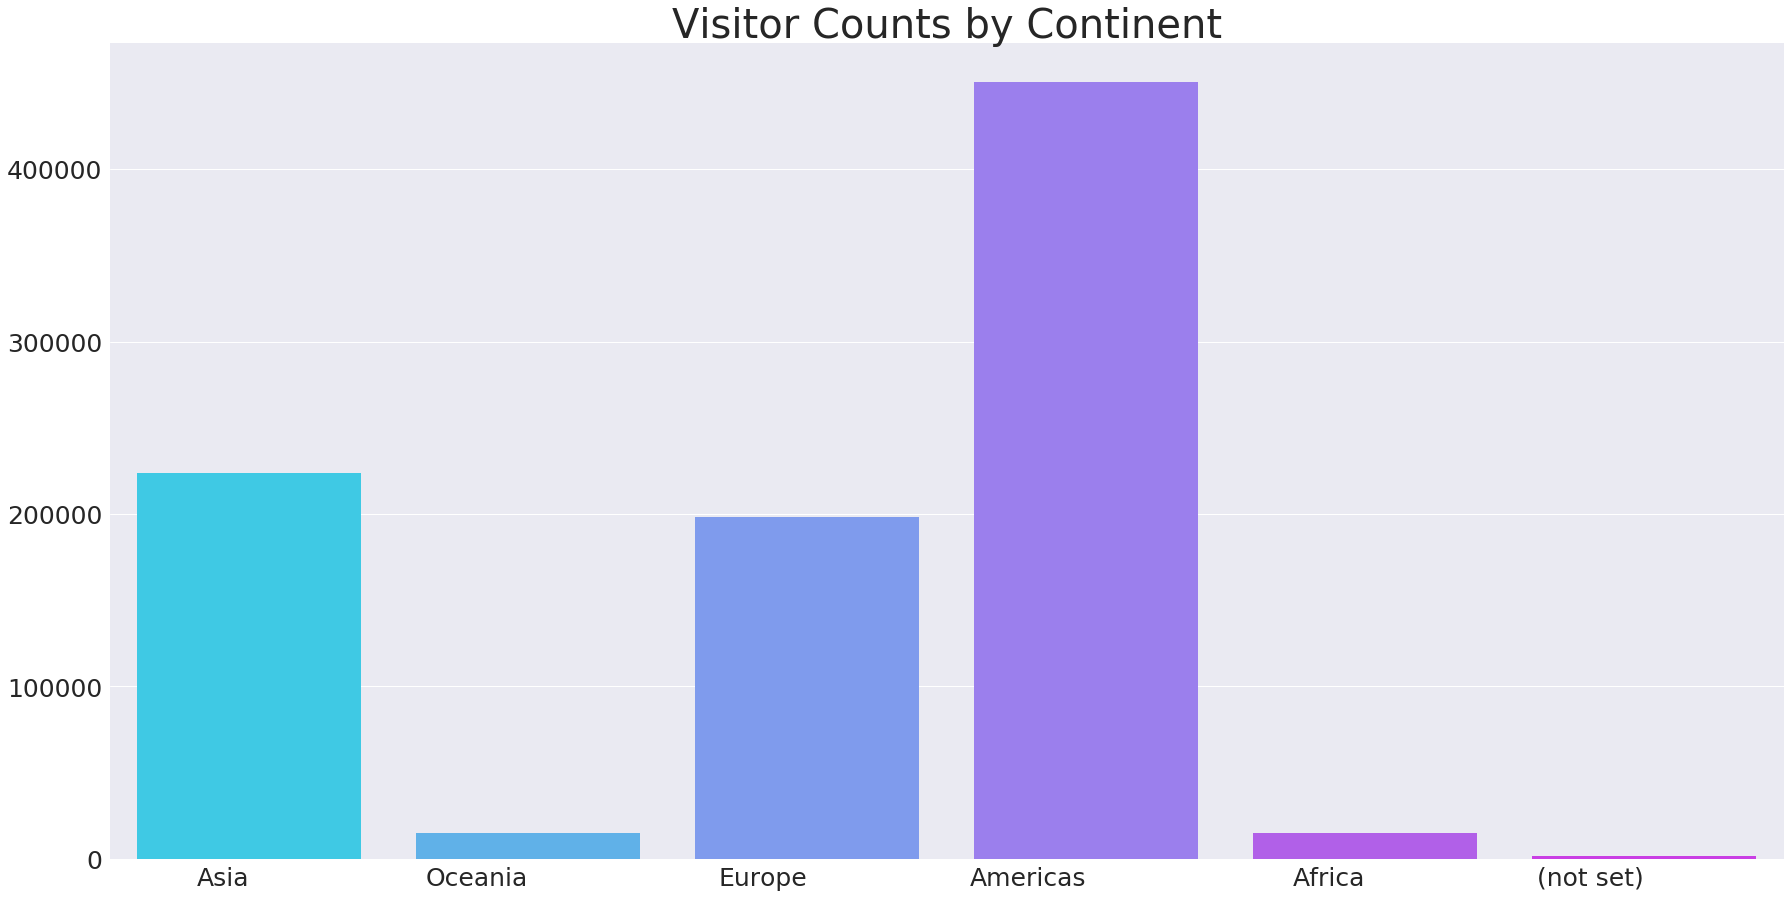

In [7]:
ax = sns.countplot(x="continent", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Visitor Counts by Continent", fontsize=40)

Now, here's the same graph, but only among those who made a purchase.

/mnt/c/Users/ok/CondaConda/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Visitors Who Made Purchase')

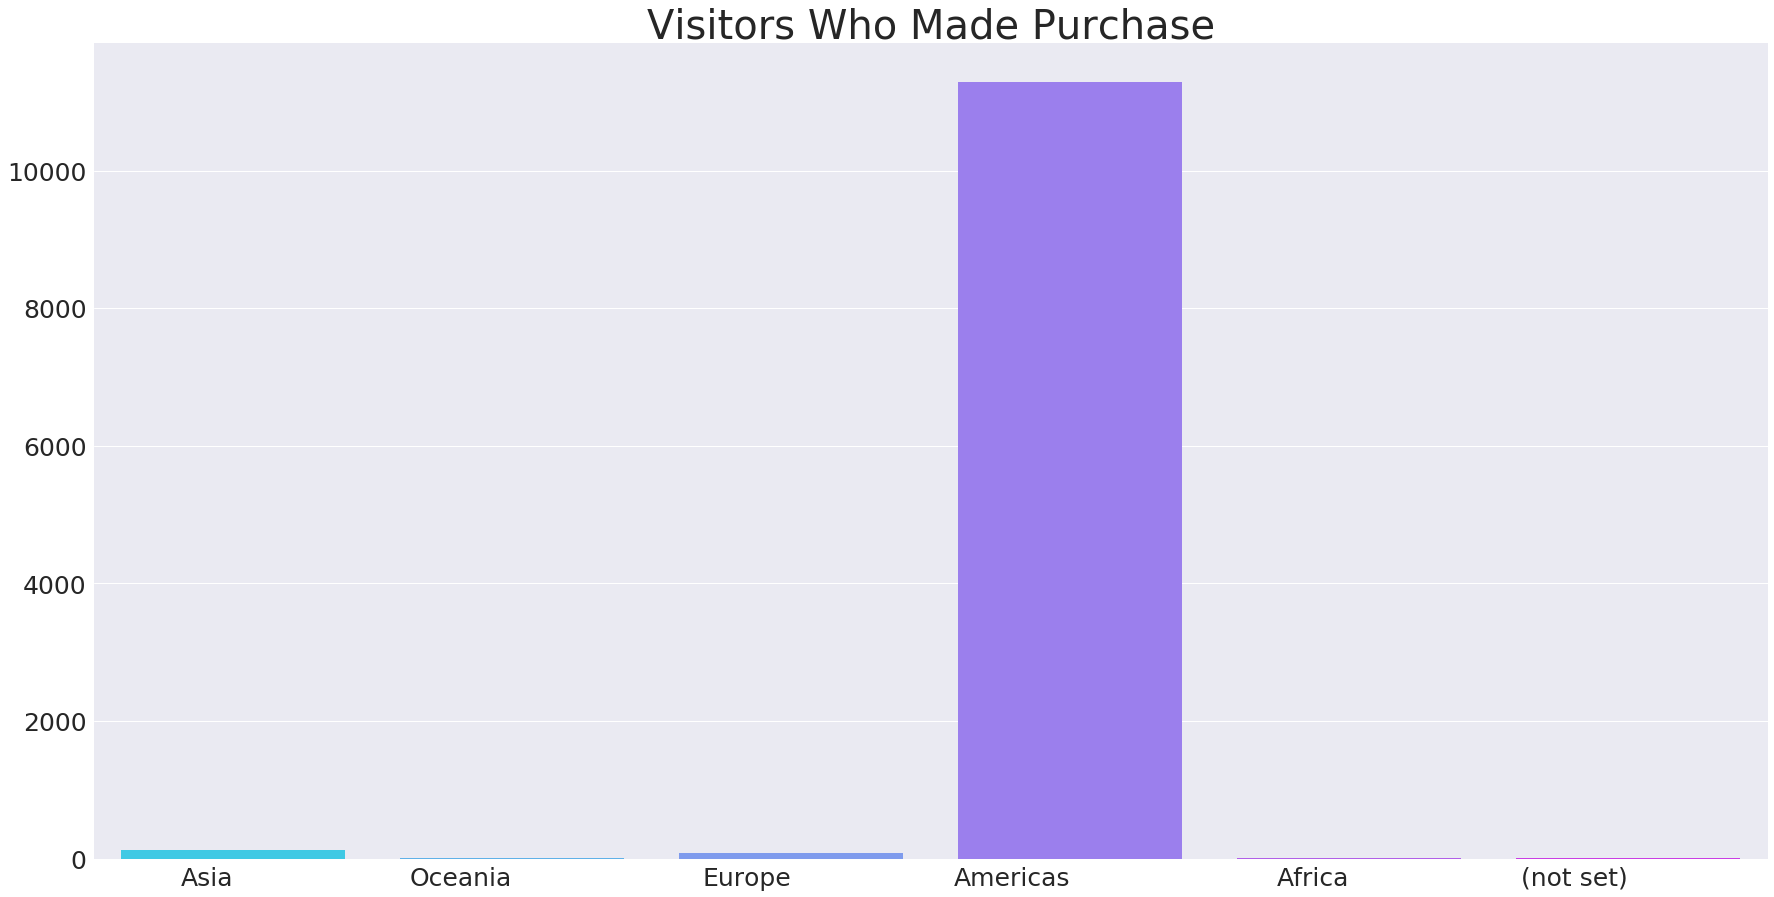

In [8]:
ax = sns.countplot(x="continent", data=df.loc[df['madePurchase'] == 1], order=["Asia", "Oceania", "Europe", "Americas", "Africa", "(not set)"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Visitors Who Made Purchase", fontsize=40)

Again, a drastic change in proportion. This suggests there is a difference made by this variable. Let's prepare the **"continent"** column to be used in our regression by creating some dummy variables.

In [9]:
df = pd.get_dummies(df, columns=['continent'])

To supplement our graphs, let's create a summary table with each of the explanatory variables.

In [10]:
#List of variables for summary table
interestvars = ['madePurchase', 'isMobile','continent_Africa', 'continent_Americas', 'continent_Asia', 'continent_Europe', 'continent_Oceania']

#Create dictionary
rows = {}
for var in interestvars:
    rows[var] = [df[var].mean(), df[var].loc[df['madePurchase'] == 1].mean()]

#Use dictionary to make dataframe to display
summarydf = pd.DataFrame.from_dict(rows, orient='index', columns = ["Total Summary", "Purchased Summary"])
summarydf

,Total Summary,Purchased Summary
madePurchase,0.012743,1.000000
isMobile,0.264618,0.088580
continent_Africa,0.016317,0.000695
continent_Americas,0.498396,0.979852
continent_Asia,0.247549,0.010855
continent_Europe,0.219455,0.006861
continent_Oceania,0.016659,0.001216


Mobile devices drop from about 26% of total visitors to only 8.8% among those purchased something. The American continents (North and South are combined) make up about half of all visits, and 98% of all purchases. This seems like a strong case to include these variables in the regression.

Let's run the logit regression.

In [11]:
contlogitmodel = smf.logit(formula='madePurchase ~ isMobile + continent_Africa + continent_Africa + continent_Americas + continent_Asia + continent_Europe + continent_Oceania', data=df).fit()
print(contlogitmodel.summary())

Optimization terminated successfully.
         Current function value: 0.059070
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:           madePurchase   No. Observations:               903653
Model:                          Logit   Df Residuals:                   903646
Method:                           MLE   Df Model:                            6
Date:                Sat, 10 Nov 2018   Pseudo R-squ.:                  0.1346
Time:                        22:24:52   Log-Likelihood:                -53379.
converged:                       True   LL-Null:                       -61679.
                                        LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.2562      0.409    -12.843      0.000      -6.058      -4.454
isMo

The Pseudo R-Squared value is 0.1346. The P-values suggest statistical significance at all levels. Coefficients from this regression can't be easily interpreted, however. To do that, we would need to get the marginal effects.

In [12]:
contmfx = contlogitmodel.get_margeff()
print(contmfx.summary())

        Logit Marginal Effects       
Dep. Variable:           madePurchase
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
isMobile              -0.0175      0.000    -40.291      0.000      -0.018      -0.017
continent_Africa      -0.0242      0.007     -3.610      0.000      -0.037      -0.011
continent_Americas     0.0228      0.005      4.490      0.000       0.013       0.033
continent_Asia        -0.0254      0.005     -4.897      0.000      -0.036      -0.015
continent_Europe      -0.0290      0.005     -5.518      0.000      -0.039      -0.019
continent_Oceania     -0.0177      0.006     -2.920      0.004      -0.030      -0.006


From these results, we can see that users on a mobile device are 1.75% less likely to make a purchase than those that aren't. Users from the American continents are 2.28% more likely to make a purchase than those from other continents.